Format largely inspired by David Wang's code for creating surrogate model for toray

# Package imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py

import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

from tqdm import tqdm
import time
import math
import random
import os
import pickle

from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

2025-01-22 13:54:13.541151: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 13:54:13.557357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737572053.575117 1234754 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737572053.580447 1234754 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 13:54:13.598738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Import dataframe

In [3]:
def split_data(data):
    # split chronologically before shuffling

    data = data.sort_values(by='shot', ascending=False)
    
    # Decide how large to make validation and test sets
    total_count = data.shape[0]
    n_val = math.floor(total_count * 0.10)
    n_test = math.floor(total_count * 0.10)
    print(n_val)
    
    # separate data into test, validation, and training sets
    data_test = data.iloc[:n_test]
    data_val = data.iloc[n_test:n_test+n_val]
    data_train = data.iloc[n_test+n_val:]
    
    training_size = len(data_train)
    
    print("Training Set Size:", len(data_train))
    print("Validation Set Size:", len(data_val))
    print("Testing Set Size:", len(data_test))
    print("Total:", len(data_train)+len(data_test)+len(data_val))

    return data_train, data_val, data_test

In [4]:
# Define your input and output columns
input_columns = [
    'pol_ang', 'tor_ang', 'Bt_center', 'Ip', 'R0', 'R_in', 'R_out', 'Z0', 'aminor', 'betan', 
    'elong', 'gapin', 'gapout', 'gaptop', 'gapbot', 'li', 'ltri', 'utri', 'volume', 'wmhd', 
    'ne_val_0', 'ne_val_1', 'ne_val_2', 'ne_val_3', 'ne_val_4', 'ne_val_5', 'ne_val_6', 
    'ne_val_7', 'ne_val_8', 'ne_val_9', 'ne_val_10', 'ne_val_11', 'ne_val_12', 'ne_val_13', 
    'ne_val_14', 'ne_val_15', 'ne_val_16', 'ne_val_17', 'ne_val_18', 'ne_val_19', 'ne_val_20'
]

input_columns = [
    'pol_ang', 'tor_ang', 'Bt_center', 'Ip', 'R0', 'Z0', 'aminor', 'betan', 
    'elong', 'li', 'volume', 
    'ne_val_0', 'ne_val_10', 'ne_val_20'
]

output_columns = ['rho_pol', 'R', 'Z', 'CD_eta']

# Load the data
df_initial = pd.read_csv("TORBEAM_all_df.csv")  # replace with your CSV file path

# Narrow down to a specific gyro and mode
temp = df_initial[df_initial['gyro'] == 'EC2']
temp = temp[temp['mode'] == -1]
# Remove rho_pol of -1
temp = temp[temp['rho_pol'] != -1]
df = temp.dropna()

# Extract input features and output targets
X = df[input_columns].values
y = df[output_columns].values

# Optional: Perform a train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Optional: Normalize features (recommended for neural networks)
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# If desired, you can also scale the outputs, especially if their ranges differ significantly.
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

In [5]:
# Build a simple feed-forward neural network
model = Sequential()
model.add(Input((X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(output_columns), activation='linear'))  # linear output for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=10**-3.2), loss='mse', metrics=['mae'])

# Stop training if validation loss does not improve for 20 epochs
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)
model.summary();

2025-01-22 13:30:37.295789: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,460 (138.52 KB)

 Trainable params: 35,460 (138.52 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
df[['R0', 'Z0']].describe()

,R0,Z0
count,647267.000000,647267.000000
mean,1.816409,-0.012625
std,0.023503,0.025684
min,1.747865,-0.100482
25%,1.795839,-0.026361
50%,1.816456,-0.017518
75%,1.832402,-0.005388
max,1.899361,0.087283


In [22]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=750,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/2000


691/691 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1733 - mae: 0.2360 - val_loss: 0.0256 - val_mae: 0.0880
Epoch 2/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0231 - mae: 0.0831 - val_loss: 0.0181 - val_mae: 0.0757
Epoch 3/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0177 - mae: 0.0723 - val_loss: 0.0156 - val_mae: 0.0712
Epoch 4/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0145 - mae: 0.0665 - val_loss: 0.0131 - val_mae: 0.0627
Epoch 5/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0127 - mae: 0.0627 - val_loss: 0.0125 - val_mae: 0.0594
Epoch 6/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0114 - mae: 0.0594 - val_loss: 0.0127 - val_mae: 0.0595
Epoch 7/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0109 - mae: 0.0574 - val_loss: 0.0101 - val_mae: 0.0556
Epoch 8/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0103 - mae: 0.0555 - val_loss: 0.0093 - val_mae: 0.0527
Epoch 9/2000
691/691 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Test Loss: 0.0042, Test MAE: 0.0338
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step


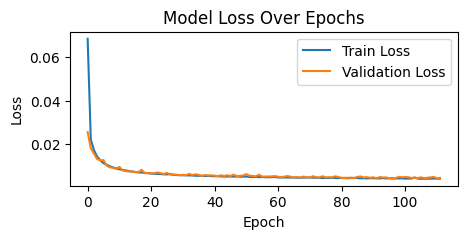

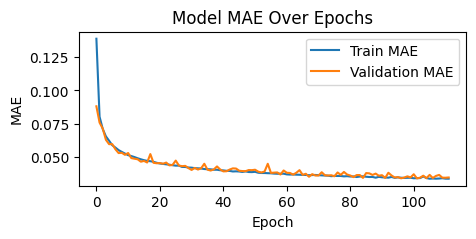

In [23]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# If you scaled the outputs, don't forget to invert the scaling of predictions for interpretation:
y_pred = model.predict(X_test)


import matplotlib.pyplot as plt

# Plot training & validation loss over epochs
plt.figure(figsize=(5, 2))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# If you also have mae or another metric:
plt.figure(figsize=(5, 2))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

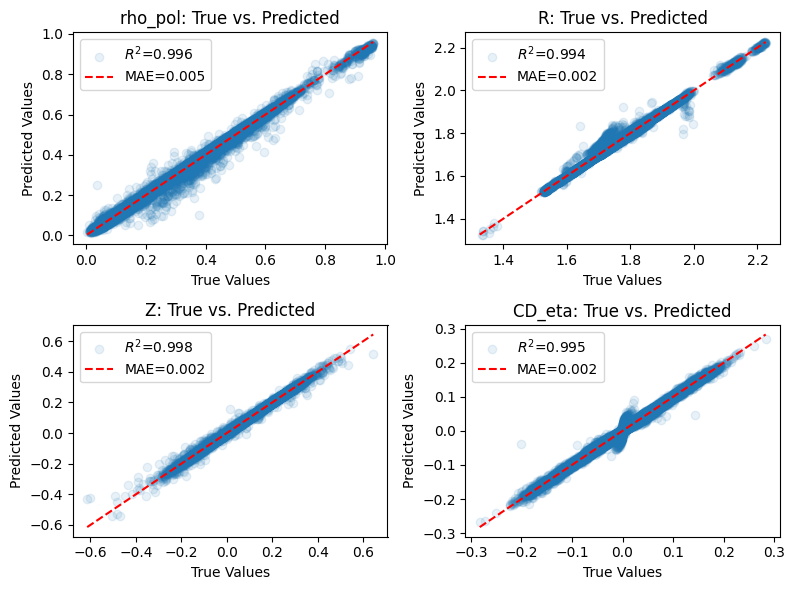

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

output_names = ['rho_pol', 'R', 'Z', 'CD_eta']

y_test_plot = scaler_y.inverse_transform(y_test)
y_pred_plot = scaler_y.inverse_transform(y_pred)

for i, ax in enumerate(axs.flat):
    r2_score = sklearn.metrics.r2_score(y_test_plot[:, i], y_pred_plot[:, i])
    mae = sklearn.metrics.mean_absolute_error(y_test_plot[:, i], y_pred_plot[:, i])
    ax.scatter(y_test_plot[:, i], y_pred_plot[:, i], alpha=0.1, label=fr'$R^2$={r2_score:.3f}')
    ax.set_title(f'{output_names[i]}: True vs. Predicted')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    # Optionally draw a perfect-fit line
    min_val = min(y_test_plot[:, i].min(), y_pred_plot[:, i].min())
    max_val = max(y_test_plot[:, i].max(), y_pred_plot[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='MAE={:.3f}'.format(mae))
    ax.legend()
    
plt.tight_layout()
plt.show()

# Final model results

In [3]:
df_initial = pd.read_csv("TORBEAM_all_df.csv")

def get_data(gyro='EC2', mode=-1):
    # Define your input and output columns
    input_columns = [
        'pol_ang', 'tor_ang', 'Bt_center', 'Ip', 'R0', 'Z0', 'aminor', 'betan', 
        'elong', 'li', 'volume', 
        'ne_val_0', 'ne_val_10', 'ne_val_20'
    ]

    output_columns = ['rho_pol', 'R', 'Z', 'CD_eta']

    # Load the data

    # Narrow down to a specific gyro and mode
    temp = df_initial[df_initial['gyro'] == gyro]
    temp = temp[temp['mode'] == mode]
    # Remove rho_pol of -1
    temp = temp[temp['rho_pol'] != -1]
    df = temp.dropna()

    # Extract input features and output targets
    X = df[input_columns].values
    y = df[output_columns].values

    # Optional: Perform a train-validation-test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Optional: Normalize features (recommended for neural networks)
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_val = scaler_X.transform(X_val)
    X_test = scaler_X.transform(X_test)

    # If desired, you can also scale the outputs, especially if their ranges differ significantly.
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train)
    y_val = scaler_y.transform(y_val)
    y_test = scaler_y.transform(y_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_X, scaler_y

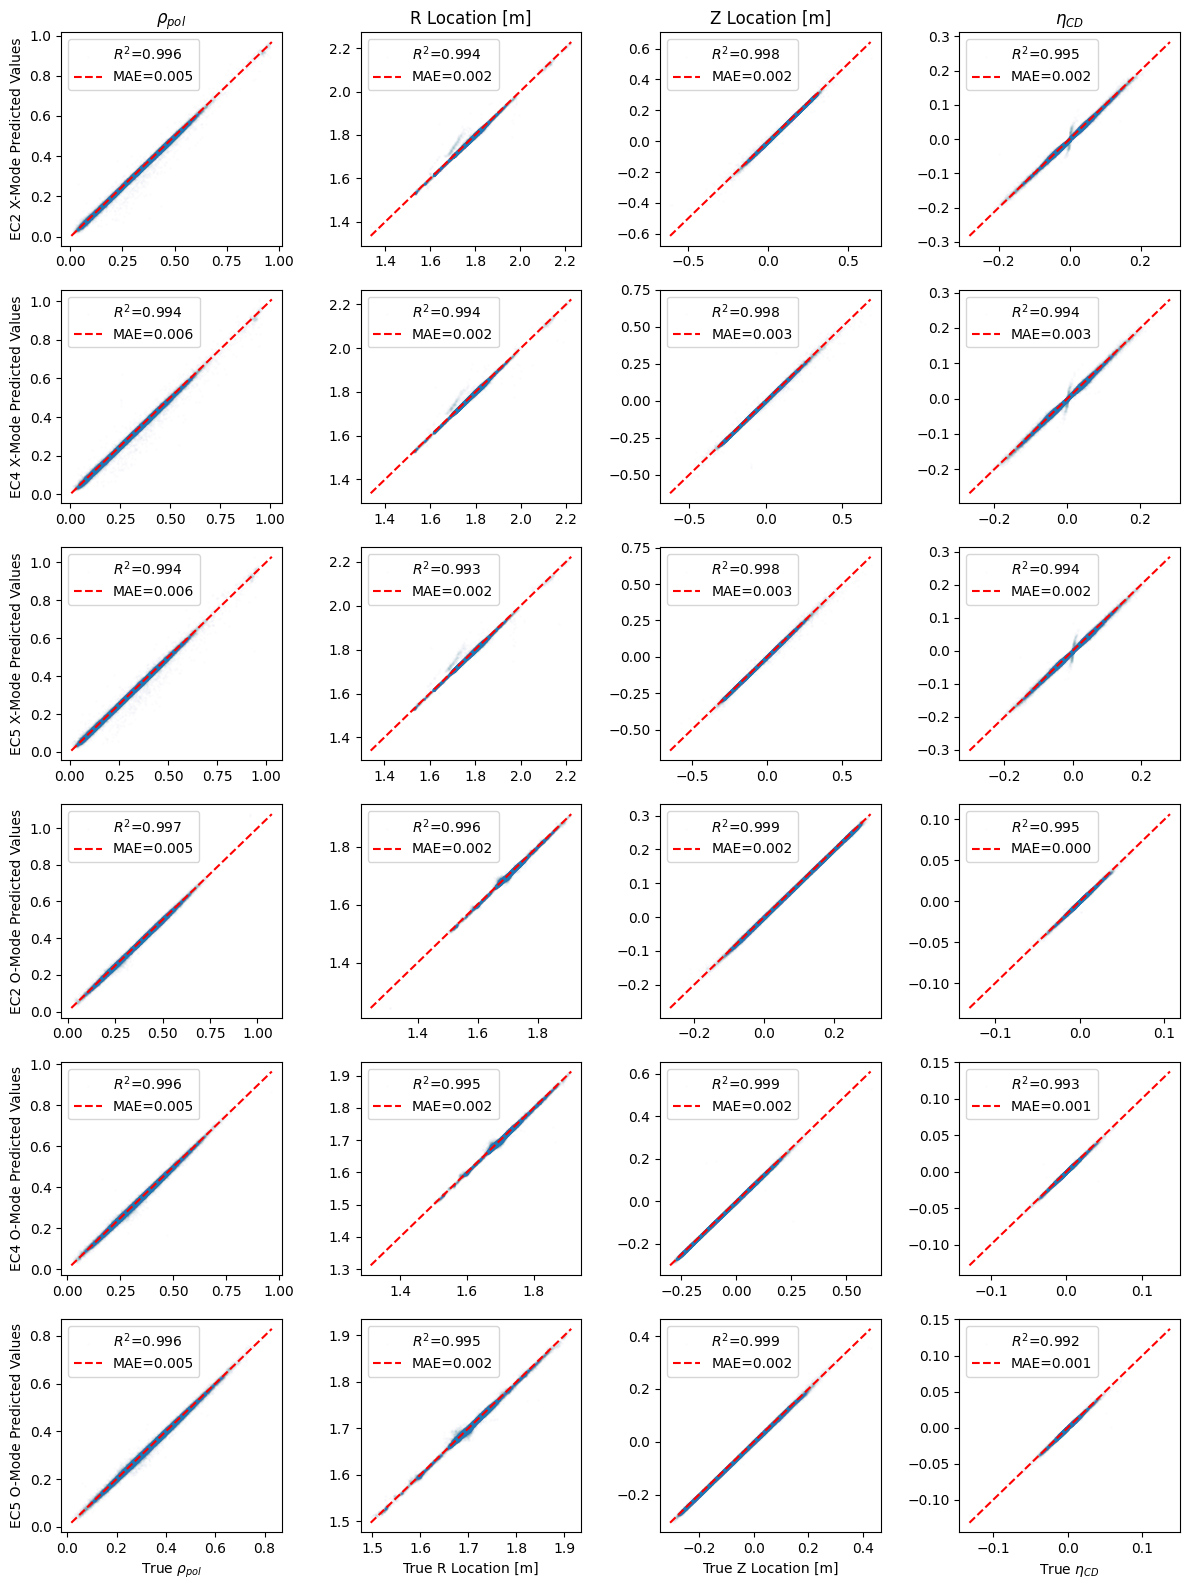

In [3]:
fig, axs = plt.subplots(6, 4, figsize=(12, 16))

output_names = ['rho_pol', 'R', 'Z', 'CD_eta']
output_names_plot = [r'$\rho_{pol}$', 'R Location [m]', 'Z Location [m]', r'$\eta_{CD}$']
num_units = 60
ind = 0

with open('r2_data.pkl', 'rb') as f:
    r2_data = pickle.load(f)

for mode in [-1, 1]:
    for gyro in ['EC2', 'EC4', 'EC5']:
        if mode == -1:
            mode_name = 'xmode'
            plt_name = 'X-Mode'
        else:
            mode_name = 'omode'
            plt_name = 'O-Mode'
        
        data = r2_data[f'{gyro}_{mode_name}']

        y_pred_plot = data['y_pred']
        y_test_plot = data['y_test']

        for i, output_name in enumerate(output_names):
            axs[0, i].set_title(output_names_plot[i])
            r2_score = data[f'{output_name}_r2']
            mae = data[f'{output_name}_mae']
            axs[ind,i].scatter(y_test_plot[:, i], y_pred_plot[:, i], alpha=0.01, label=fr'$R^2$={r2_score:.3f}', s=0.5)
            axs[ind,0].set_ylabel(f'{gyro} {plt_name} Predicted Values')
            # Optionally draw a perfect-fit line
            min_val = min(y_test_plot[:, i].min(), y_pred_plot[:, i].min())
            max_val = max(y_test_plot[:, i].max(), y_pred_plot[:, i].max())
            axs[ind,i].plot([min_val, max_val], [min_val, max_val], 'r--', label='MAE={:.3f}'.format(mae))
            axs[ind,i].legend()
            axs[5, i].set_xlabel(f'True {output_names_plot[i]}')
        ind += 1
    
plt.tight_layout()
plt.show()